In [1]:
!pip install --upgrade tensorflow==2.12.0 --quiet

In [2]:
!pip install datasets --quiet

# Laboratory work #2

## Downloading Dataset
My dataset is Airbus Ship Detection Challenge (from [kaggle](https://www.kaggle.com/competitions/airbus-ship-detection))

In [5]:
import tensorflow as tf
from keras.utils import Sequence, img_to_array
from keras import layers
from keras.layers import Input, ReLU, Activation, BatchNormalization
from keras.layers import RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom
from keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.losses import Loss
from keras.metrics import Metric
from keras.optimizers import Adam
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K_back


# Import other libraries
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from pathlib import Path
import random
import os

## Prepare help functions

### Super Resolution CNN

In [ ]:
np.random.seed(17)

In [ ]:
def resize_image(image_array, factor):
    """"""
    original_image = Image.fromarray(image_array)

    new_size = np.array(original_image.size) * factor
    new_size = new_size.astype(np.int32)
    new_size = tuple(new_size)

    resized = original_image.resize(new_size)
    resized = img_to_array(resized)
    resize = resized.astype(np.uint8)

    return resized

In [ ]:
def downsize_upsize_image(image, scale):
    """"""
    scaled = resize_image(image, 1.0 / scale)
    scaled = resize_image(scaled, scale / 1.0)
    return scaled

In [ ]:
def tight_crop_image(image, scale):
    """"""
    height, width = image.shape[:2]
    width -= int(width % scale)
    height -= int(height % scale)
    return image[:height, width]

In [ ]:
def crop_input(image, x, y, input_dim):
    """"""
    y_slice = slice(y, y + input_dim)
    x_slice = slice(x, x + input_dim)
    return image[y_slice, x_slice]

In [ ]:
def crop_output(image, x, y, pad, label_size):
    """"""
    y_slice = slice(y + pad, y + pad + label_size)
    x_slice = slice(x + pad, x + pad + label_size)
    return image[y_slice, x_slice]

In [ ]:
class PatchesDataset(Sequence):
    def __init__(self, batch_size, *args, **kwargs):
        self.batch_size = batch_size
        self.input = [*glob("data/*_intput.np.npy")]
        self.output = [*glob("data/*_output.np.npy")]
        self.input.sort()
        self.output.sort()
        self.total_data = len(self.input)

    def __len__(self):
        """Returns the number of batches"""
        return int(self.total_data / self.batch_size)

    def __getitem__(self, index):
        """Return data of one batch"""
        indices = self.random_indices()
        input = np.array([np.load(self.input[idx]) for idx in indices])
        output = np.array([np.load(self.output[idx]) for idx in indices])
        return input, output

    def random_indices(self):
        """Return random indices of dataset data"""
        return np.random.choice(list(range(self.total_data)), self.batch_size,
                                p=np.ones(self.total_data) / self.total_data)

In [ ]:
def build_image_from_patches(model, scaled_image, input_dim, label_size, pad):
    """"""
    output = np.zeros(scaled_image.shape)
    height, width = output.shape[:2]

    for y in range(0, height - input_dim + 1, label_size):
        for x in range(0, width - input_dim + 1, label_size):
            crop = crop_input(scaled_image, x, y)
            image_batch = np.expand_dims(crop, axis=0)

            prediction = model.predict(image_batch)

            new_shape = (label_size, label_size, 3)
            prediction = prediction.reshape(new_shape)

            output_y_slice = slice(y + pad, y + pad + label_size)
            output_x_slice = slice(x + pad, x + pad + label_size)
            output[output_y_slice, output_x_slice] = prediction

    return output

### Segmentation

In [ ]:
def tf_rle_decode(rle_string, shape=(768, 768)):
    """
    Function for decoding run-length encoding mask from string;
    :param rle_string: run-length string from csv file;
    :param shape: shape of output image;
    :return: tensor as image mask.
    """
    # Initialize tensor as shape of image
    shape_tensor = tf.convert_to_tensor(shape, tf.int64)
    # Initialize tensor of image size
    size = tf.math.reduce_prod(shape)

    # Split and convert string to tensor of number from string
    rle_tensor = tf.strings.split(rle_string)
    rle_tensor = tf.strings.to_number(rle_tensor, tf.int64)

    # Split start and lengths data from rle string
    starts = rle_tensor[::2] - 1
    lengths = rle_tensor[1::2]

    # Make ones to be scattered
    total_ones = tf.reduce_sum(lengths)
    ones = tf.ones([total_ones], tf.uint8)

    # Make scattering indices
    ones_range = tf.range(total_ones)
    lens_cumsum = tf.math.cumsum(lengths)
    rle_ssorted = tf.searchsorted(lens_cumsum, ones_range, 'right')
    idx = ones_range + tf.gather(starts - tf.pad(lens_cumsum[:-1], [(1, 0)]), rle_ssorted)

    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])

    # Reshape into mask
    return tf.reshape(mask_flat, shape_tensor)

In [5]:
def load_prepare_image(image_path, image_size=(256, 256)):
    """
    Loading and processing image from directory;
    :param image_path: path to image;
    :param image_size: size of image for processing;
    :return: processed image.
    """
    # Read image file from directory
    image = tf.io.read_file(image_path)
    # Define image size in tensor format
    tensor_size = tf.constant(image_size)
    # Decode image file to colour image tensor
    decoded_image = tf.image.decode_jpeg(image, channels=3)  # channels -- colour channels
    # # Convert uint8 tensor to floats in the [0, 1] range
    # decoded_image = tf.image.convert_image_dtype(decoded_image, tf.float32)
    # # Resize the image into tensor_size of determine size
    # decoded_image = tf.image.resize(decoded_image, size=tensor_size)

    return decoded_image

In [6]:
def train_valid_ids_split(list_ids, train_split=0.8):
    """
    Splitting list ids to train and validation list with ids;
    :param list_ids: list with train list_ids;
    :param train_split: float per cent value of training split size;
    :return: two list of train and validation ids.
    """
    # Define size of list with ids
    list_size = np.size(list_ids)
    # Define train size of list with ids
    train_size = int(train_split * list_size)
    # Set train & validation list with ids
    train_list_ids = list_ids[:train_size]
    valid_list_ids = list_ids[train_size:]

    return train_list_ids, valid_list_ids

In [ ]:
class ASDGenerator(Sequence):
    """Class generates data for Keras model (Segmentation task)"""

    def __init__(self, list_ids, gt_df, mode="fit", base_path="input/dataset/train", batch_size=32,
                 image_size=(256, 256), color_channels=3, random_state=17, shuffle=True):
        """
        :param list_ids: list with ids that data will be generated for;
        :param gt_df: ground truth pandas.DataFrame(), with data that will be generated for ids from list_ids;
        :param mode: string var that indicate data generated mode;
        :param base_path: string with the path where the images are stored;
        :param batch_size: number of the batch size;
        :param image_size: the shape of the image that will be processed in the model;
        :param color_channels: number of color channels;
        :param random_state: random state for shuffle image ids from list_ids;
        :param shuffle: bool that indicates, shuffling image ids or not;
        """
        self.image_size = image_size
        self.batch_size = batch_size
        self.gt_df = gt_df
        self.mode = mode
        self.base_path = base_path
        self.list_ids = list_ids
        self.color_channels = color_channels
        self.shuffle = shuffle
        self.random_state = random_state

        # Init indexes array for store all indexes
        self.indexes = np.array([])
        # Run on_epoch_end method for shuffle and init "indexes" attribute
        self.on_epoch_end()
        # First set random seed
        np.random.seed(self.random_state)

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle is True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        # Find list of IDs
        list_ids_batch = [self.list_ids[k] for k in indexes]
        # Generate X variable that contains images
        X = self.__generate_x(list_ids_batch)
        # Check string attribute mode for 'fit' mode
        if self.mode == "fit":
            # Generate y variable that contains masks for images
            y = self.__generate_y(list_ids_batch)
            # And return batch X and y variable
            return X, y
        # Check string attribute mode for 'predict' mode
        elif self.mode == "predict":
            # Return only one variable X (images)
            return X
        else:
            # When mode is no 'fit' or 'predict' then rise Attribute Error
            raise AttributeError("The mode parameter must be set to 'fit' or 'predict'.")

    def __generate_x(self, list_ids_batch):
        """Generates data (images) in the current batch sample"""
        # Initialization X as an empty numpy.array with determined shape
        X = np.empty((self.batch_size, *self.image_size, self.color_channels))
        # Generate data from gt_df with ids from list_ids_batch
        for i, ID in enumerate(list_ids_batch):
            image_id = self.gt_df["ImageId"].iloc[ID]
            image_path = f"{self.base_path}/{image_id}"
            image = load_prepare_image(image_path, self.image_size)
            # Store sample image in numpy.array
            X[i, ] = image

        return X

    def __generate_y(self, list_ids_batch):
        """Generates masks for the image in the current batch sample"""
        # Initialization y as an empty numpy array with determined shape
        y = np.empty((self.batch_size, *self.image_size, 1))
        # Generate masks from gt_df with ids from list_ids_batch
        for i, ID in enumerate(list_ids_batch):
            # Extract image id for get masks from gt_df
            image_id = self.gt_df["ImageId"].iloc[ID]
            # Get masks for concrete image
            gt_df = self.gt_df[self.gt_df["ImageId"] == image_id]
            # Get coded rle string from dataframe of masks for concrete image
            coded_rle_strings = gt_df["EncodedPixels"].values
            # Set tensor with zeros value for all masks
            # (768, 768) - it's shape of ground truth masks
            all_masks = tf.zeros((768, 768), dtype=tf.uint8)
            # Iter through rle strings of all masks for concrete image
            for mask in coded_rle_strings:
                # Add mask to only one tensor for all masks
                all_masks += tf.transpose(tf_rle_decode(mask))

            # Resize masks to image_size for model
            all_masks = tf.image.resize(tf.expand_dims(all_masks, -1), size=self.image_size)
            # Store sample mask in y (numpy.array)
            y[i, ] = all_masks

        return y

In [ ]:
def get_model(image_size, num_classes):
    """
    Function for construct the model;
    :param image_size: size of the images which will be used model when getting data;
    :param num_classes: that number of classes that model will be predicted on the image;
    :return: built Keras model.
    """
    # Create data augmentation layer
    data_augmentation = Sequential([
        RandomFlip('horizontal'),  # randomly flip images on horizontal edge
        RandomRotation(0.1),  # randomly rotate images by a specific amount
        RandomHeight(0.003),  # randomly adjust the height of an image by a specific amount
        RandomWidth(0.003),  # randomly adjust the width of an image by a specific amount
        RandomZoom(0.1),  # randomly zoom into an image
    ])

    # Initialize Input layer
    inputs = Input(shape=image_size + (3,))
    # Initialize Data augmentation layer
    # x = data_augmentation(inputs)  # augment images (only happens during training)

    # ## [First half of the network: down-sampling inputs] ## #

    # Entry block
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = Activation('relu')(x)
        x = SeparableConv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding='same')(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # ## [Second half of the network: up-sampling inputs] ## #

    for filters in [256, 128, 64, 32]:
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = Conv2DTranspose(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation='sigmoid', padding='same')(x)

    # Define the model
    model = Model(inputs, outputs)

    return model

In [ ]:
def plot_history_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    :param history: history from process of training model.
    :return: plotted separate curves for training and validation.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    dice_score = history.history['dice_score']
    val_dice_score = history.history['val_dice_score']

    epochs = range(len(history.history['loss']))

    # Plotting loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # Plotting dice_score
    plt.figure()
    plt.plot(epochs, dice_score, label='training_dice_score')
    plt.plot(epochs, val_dice_score, label='val_dice_score')
    plt.title('Dice Score')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [ ]:
class DiceLoss(Loss):
    """Class for creating the loss function is named dice loss in compiling the model."""
    def __init__(self, name='dice_loss', gama=2):
        """
        Initialize attribute for class;
        :param name: name of this loss function;
        :param gama: some constant for squaring y_true and y_pred
        """
        super(DiceLoss, self).__init__(name=name)
        self.gama = gama

    def call(self, y_true, y_pred):
        """Compute dice loss"""
        y_true, y_pred = np.cast(y_true, dtype=tf.float32), np.cast(y_pred, dtype=tf.float32)

        nominator = 2 * np.reduce_sum(np.abs(np.multiply(y_pred, y_true)))
        denominator = np.reduce_sum(y_pred ** self.gama) + np.reduce_sum(y_true ** self.gama)

        return 1 - np.divide(nominator, denominator)

In [ ]:
class DiceScore(Metric):
    """Class for use metric dice score (f1-score) in model compile metrics."""
    def __init__(self,
                 name='dice_score',
                 dtype='float32',
                 num_classes=2,
                 **kwargs):
        """
        Initialize attribute for class;
        :param name: refers to the name of the metric;
        :param dtype: it's data type for this metric;
        """
        super().__init__(name=name, dtype=dtype, **kwargs)
        # Setting begin confusion matrix
        self.total_cm = self.add_weight(
                "total_confusion_matrix",
                shape=(num_classes, num_classes),
                initializer="zeros"
        )
        self.num_classes = num_classes

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulate the prediction to current confusion matrix."""
        current_cm = tf.math.confusion_matrix(
                y_true,
                y_pred,
                self.num_classes,
                weights=sample_weight,
                dtype=self._dtype
        )

        self.total_cm.asssifn_add(current_cm)

    def result(self):
        """Compute the Dice score via the confusion matrix."""
        sum_over_row = tf.cast(
                tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype
        )
        sum_over_col = tf.cast(
                tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype
        )

        true_positives = tf.cast(
                tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype
        )

        # sum_over_row + sum_over_col =
        #       2 * true_positives + false_positives + false_negatives
        denominator = sum_over_row + sum_over_col

        # If the denominator is o, we need to ignore the class.
        num_valid_entries = tf.reduce_sum(
                tf.cast(tf.not_equal(denominator, 0), dtype=self._dtype)
        )

        return tf.math.divide_no_nan(2 * true_positives, denominator)

    def reset_state(self):
        """Override reset_state method from Metric"""
        K_back.set_value(
                self.total_cm, np.zeros((self.num_classes, self.num_classes))
        )

### Fast Gradient Attack

In [ ]:
loss_object = DiceLoss()

In [ ]:
def create_adversarial_pattern(model, input_image, input_label):
    """"""
    with tf.GradientTape() as gtape:
        gtape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = gtape.gradient(loss, input_image)
    # Get the sign of the gradient to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [ ]:
def display_image(image, perturbations, epsilons):
    """"""
    for i, eps in enumerate(epsilons):
        adv_x = image + eps * perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)

        title_description = "Epsilon = {:.2f}".format(eps)

        plt.subplots(1, 2, figsize=(15, 8))
        plt.subplot(1, 1)
        plt.imshow(image)
        plt.axis("off")
        plt.subplot(1, 2)
        plt.imshow(adv_x)
        plt.axis("off")
        plt.title = title_description
        plt.show()

## Super Resolution CNN model

### Preprocess Data

In [7]:
# Add hyperparameters
image_size = (256, 256)
down_scale = 4
# Add some variables
np.random.seed(17)

In [ ]:
# View on test high and low resolution samples
fig, ax = plt.subplots(1, 2, figsize=(15, 30))
ax[0].axis("off")
ax[1].axis("off")
ax[0].imshow(data[7])
ax[1].imshow(labels[7])
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

### Build model

In [ ]:
# Define hyperparameters
input_shape = (33, 33, 3)
epochs = 12
batch_size = 512
adam_opt = Adam(learning_rate=1e-3, decay=1e-3 / epochs)

In [ ]:
# Build model
def create_srcnn(input_shape):

    input = Input(shape=input_shape)
    x = Conv2D(64, 9, kernel_initializer="he_normal")(input)
    x = ReLU()(x)
    x = Conv2D(32, 1, kernel_initializer="he_normal")(x)
    x = ReLU()(x)
    output = Conv2D(input_shape[2], 5, kernel_initializer="he_normal")(x)
    return Model(input, output)

In [ ]:
srcnn_model = create_srcnn(input_shape)
srcnn_model.compile(
    loss='mse',
    optimizer=adam_opt
    )

### Fit model

In [ ]:
srcnn_model.fit(

    )

### Evaluate model

## Segmentation

### Preprocess Data

In [ ]:
# Add hyperparameters
batch_size = 32
image_size = (768, 768)
# Add some variables
base_path = "input/asd_dataset/"

In [ ]:
# View how many images we have
num_train_images = len(os.listdir(f"{base_path}train"))
num_test_images = len(os.listdir(f"{base_path}test"))
print(f"Number of images for training: {num_train_images}")
print(f"Number of images for testing: {num_test_images}")

Number of images for training: 8760
Number of images for testing: 8318


In [ ]:
def view_random_image(target_dir, target_type):
    """Plotting one random image from dataset"""
    # Setup target directory
    target_folder = target_dir + target_type
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    # Read the image and plot it
    img = tf.io.read_file(f"{target_folder}/{random_image[0]}")
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    plt.imshow(img)
    plt.title(random_image)
    plt.axis("off")

    # Show the shape of the image
    print(f"Image shape: {img.shape}")
    return img

Image shape: (768, 768, 3)


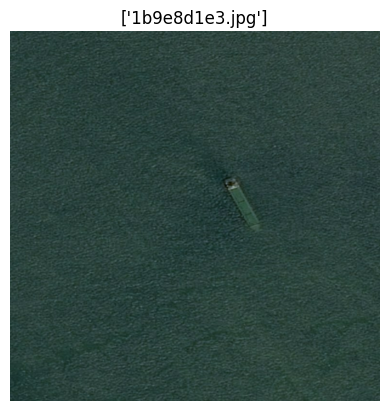

In [ ]:
# View a random image from the training dataset
image = view_random_image(base_path, "train")

In [ ]:
# View the tensor of image
image

<tf.Tensor: shape=(768, 768, 3), dtype=float32, numpy=
array([[[0.18431373, 0.28627452, 0.27450982],
        [0.18039216, 0.28235295, 0.27058825],
        [0.18823531, 0.2901961 , 0.2784314 ],
        ...,
        [0.19607845, 0.28627452, 0.25490198],
        [0.21568629, 0.3019608 , 0.2901961 ],
        [0.22352943, 0.30980393, 0.29803923]],

       [[0.16470589, 0.26666668, 0.25490198],
        [0.1764706 , 0.2784314 , 0.26666668],
        [0.19215688, 0.29411766, 0.28235295],
        ...,
        [0.18823531, 0.2784314 , 0.24705884],
        [0.20784315, 0.29803923, 0.27450982],
        [0.21568629, 0.3019608 , 0.2901961 ]],

       [[0.15294118, 0.25490198, 0.24313727],
        [0.17254902, 0.27450982, 0.2627451 ],
        [0.19607845, 0.29803923, 0.28627452],
        ...,
        [0.18431373, 0.27450982, 0.24313727],
        [0.20392159, 0.29411766, 0.27058825],
        [0.21176472, 0.3019608 , 0.2784314 ]],

       ...,

       [[0.12156864, 0.21960786, 0.19607845],
        [0.11

In [ ]:
# View the image shape
image.shape

TensorShape([768, 768, 3])

In [ ]:
# Check the *.csv files to use that later
# load train_ship_segmentations_v2.csv to pandas.DataFrame()
train_ground_truth = pd.read_csv(base_path + "train_ship_segmentations_v2.csv")
train_ground_truth.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [ ]:
# View number of masks for segmentations
num_masks = train_ground_truth.shape[0]
num_masks

231723

In [ ]:
# Check ImageId of image with index 2
train_ground_truth.ImageId[2]

'000155de5.jpg'

In [ ]:
# Check EncodedPixels (masks) of image with index 2
train_ground_truth.EncodedPixels[2]

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

In [ ]:
# View mask tensor of image with index 2
rle_tensor = tf.strings.to_number(tf.strings.split(train_ground_truth.EncodedPixels[2]), tf.int64)
rle_tensor

<tf.Tensor: shape=(208,), dtype=int64, numpy=
array([264661,     17, 265429,     33, 266197,     33, 266965,     33,
       267733,     33, 268501,     33, 269269,     33, 270037,     33,
       270805,     33, 271573,     33, 272341,     33, 273109,     33,
       273877,     33, 274645,     33, 275413,     33, 276181,     33,
       276949,     33, 277716,     34, 278484,     34, 279252,     33,
       280020,     33, 280788,     33, 281556,     33, 282324,     33,
       283092,     33, 283860,     33, 284628,     33, 285396,     33,
       286164,     33, 286932,     33, 287700,     33, 288468,     33,
       289236,     33, 290004,     33, 290772,     33, 291540,     33,
       292308,     33, 293076,     33, 293844,     33, 294612,     33,
       295380,     33, 296148,     33, 296916,     33, 297684,     33,
       298452,     33, 299220,     33, 299988,     33, 300756,     33,
       301524,     33, 302292,     33, 303060,     33, 303827,     34,
       304595,     34, 305363, 

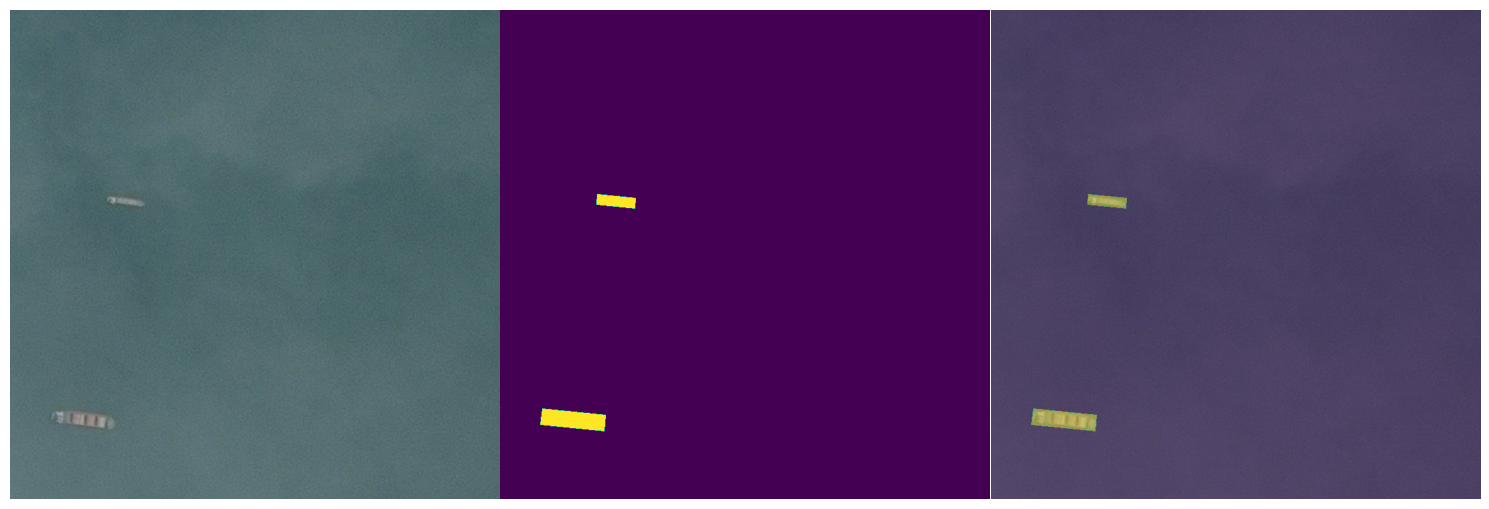

In [ ]:
# Get a random image path
image_id = random.sample(os.listdir(f"{base_path}/train"), 1)
# Read the image
image = tf.io.read_file(f"{base_path}/train/{image_id[0]}")
image = tf.image.decode_jpeg(image, channels=3)
# Make a list with the masks that image_id match
image_masks = train_ground_truth.loc[train_ground_truth["ImageId"] == str(image_id[0]), "EncodedPixels"].tolist()
# Take the individual ship masks and create a single mask array for all ships
# Set tensor with zeros value for all masks; (768, 768) - it's shape of ground truth masks
all_masks = tf.zeros((768, 768), dtype=tf.uint8)
# Iter through rle strings of all masks for concrete image
for mask in image_masks:
    # Add mask to only one tensor for all masks
    all_masks += tf.transpose(tf_rle_decode(mask))

# Create plot with 3 different sight of image (with masks)
fig, ax = plt.subplots(1, 3, figsize=(15, 40))
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[0].imshow(image)
ax[1].imshow(all_masks)
ax[2].imshow(image)
ax[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

### Build model

### Fit model

### Evaluate model

## Fast Gradient Sign Attack

### Preprocess data

### Build gradient sign

### Use gradient